In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers


import matplotlib.pyplot as plt

import sys

import numpy as np

In [2]:
# Set the seed for reproducible result
np.random.seed(1000)

randomDim = 10 
# Load MNIST data
(X_train, _), (_, _) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(60000, 784)

**Now we will need to build a generator and discriminator. The purpose of the
generator is to take in a noisy input and generate an image similar to the training
dataset. The size of the noisy input is decided by the variable randomDim; you
can initialize it to any integral value. Conventionally people set it to 100. For our
implementation we tried a value of 10. This input is fed to a Dense layer with
256 neurons with LeakyReLU activation. We next add another Dense layer with
512 hidden neurons, followed by the third hidden layer with 1024 neurons and
finally the output layer with 784 neurons. You can change the number of neurons
in the hidden layers and see how the performance changes; however, the number
of neurons in the output unit has to match the number of pixels in the training
images. The corresponding generator is then:**

In [3]:
# Optimizer
adam = Adam(learning_rate = 0.0002, beta_1 = 0.5)

generator = Sequential()
generator.add(Dense(256, input_dim=randomDim)) #, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))
#generator.compile(loss='binary_crossentropy', optimizer=adam)

**Similarly, we build a discriminator. Notice now that the discriminator takes in the
images, either from the training set or images generated by generator, thus its input
size is 784. The output of the discriminator however is a single bit, with 0 signifying
a fake image (generated by generator) and 1 signifying that the image is from the
training dataset:**

In [4]:
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784,))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

**Next, we combine the generator and discriminator together to form a GAN. In the
GAN we ensure that the discriminator weights are fixed by setting the trainable
argument to False:**

In [5]:
# Combined network
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

dLosses = []
gLosses = []

**The trick to train the two is that we first train the discriminator separately; we
use binary cross entropy loss for the discriminator. Later we freeze the weights of
the discriminator and train the combined GAN; this results in the training of the
generator. The loss this time is also binary cross entropy:**

In [6]:
# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/gan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def saveGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images/gan_generated_image_epoch_%d.png' % epoch)
    plt.show()

**Let us now perform the training. For each epoch we take a sample of random noise
first, feed it to the generator, and the generator produces a fake image. We combine
the generated fake images and the actual training images in a batch with their
specific labels and use them to train the discriminator first on the given batch:**

In [7]:
def train(epochs=200, batchSize=256):
    batchCount = int(X_train.shape[0] / batchSize)
    print ('Epochs:', epochs)
    print ('Batch size:', batchSize)
    print ('Batches per epoch:', batchCount)

    for e in range(epochs):
        print ('-'*15, 'Epoch %d' % (e+1), '-'*15)
        for _ in range(batchCount):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        if e % 5 == 0:
            saveGeneratedImages(e)
            

    # Plot losses from every epoch
    plotLoss(e)

Epochs: 200
Batch size: 256
Batches per epoch: 234
--------------- Epoch 1 ---------------


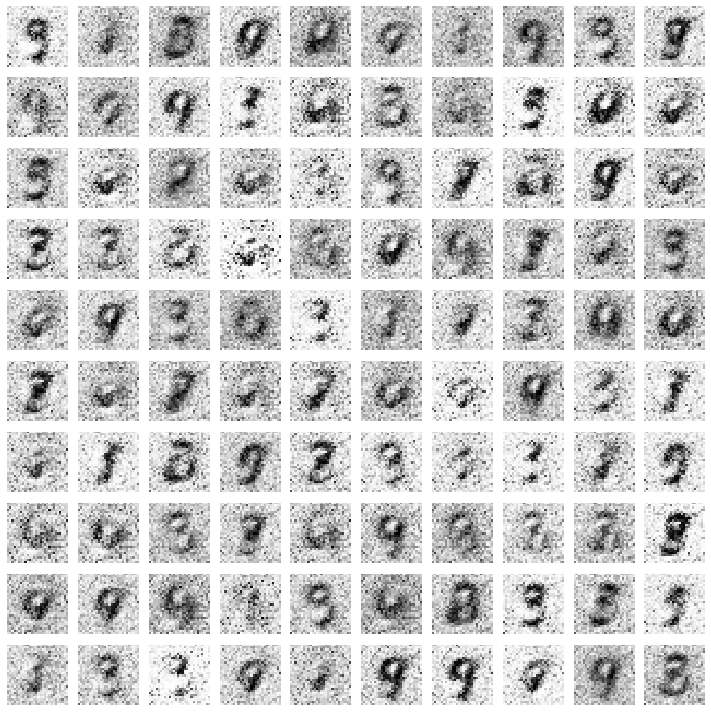

--------------- Epoch 2 ---------------
--------------- Epoch 3 ---------------
--------------- Epoch 4 ---------------
--------------- Epoch 5 ---------------
--------------- Epoch 6 ---------------


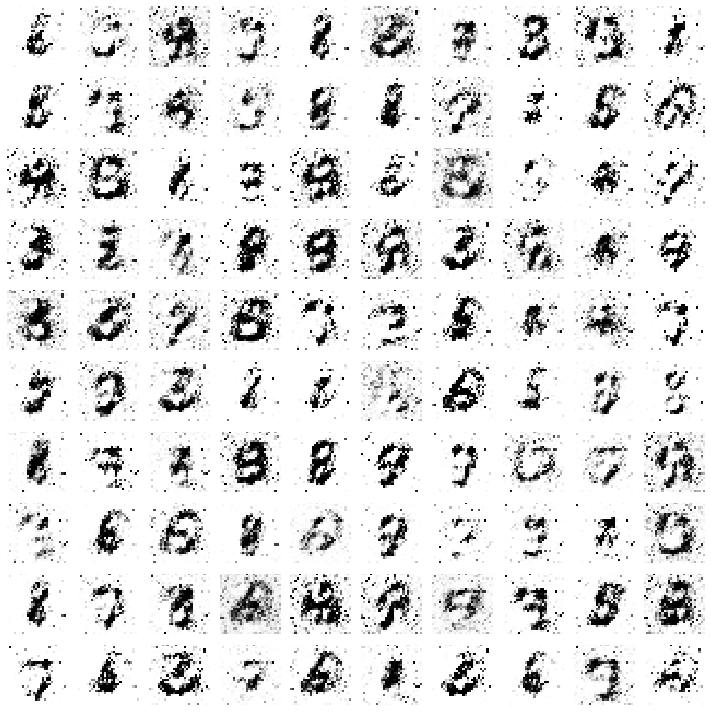

--------------- Epoch 7 ---------------
--------------- Epoch 8 ---------------
--------------- Epoch 9 ---------------
--------------- Epoch 10 ---------------
--------------- Epoch 11 ---------------


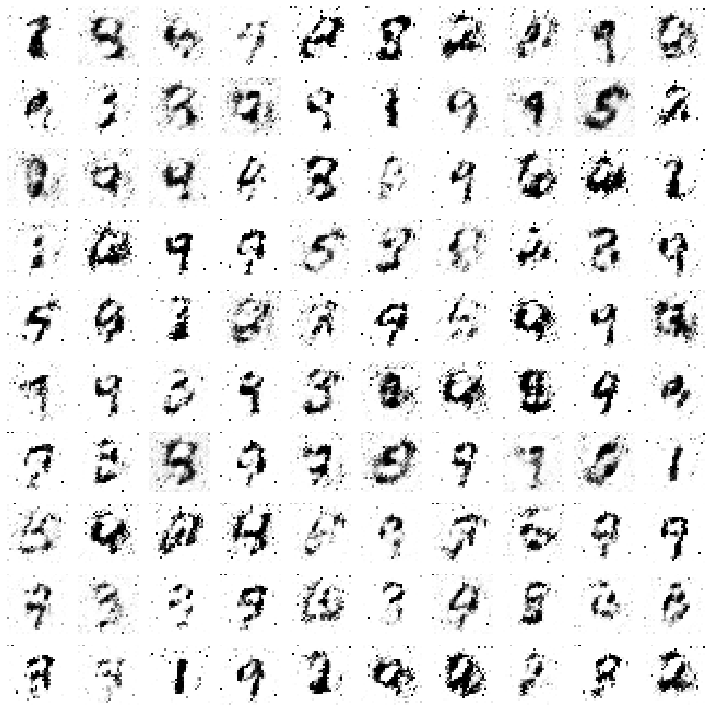

--------------- Epoch 12 ---------------
--------------- Epoch 13 ---------------
--------------- Epoch 14 ---------------
--------------- Epoch 15 ---------------
--------------- Epoch 16 ---------------


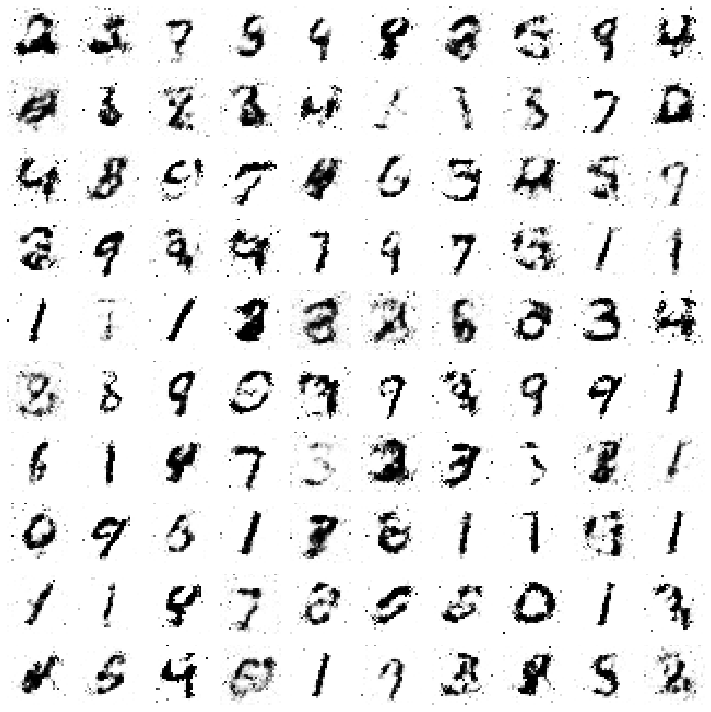

--------------- Epoch 17 ---------------
--------------- Epoch 18 ---------------
--------------- Epoch 19 ---------------
--------------- Epoch 20 ---------------
--------------- Epoch 21 ---------------


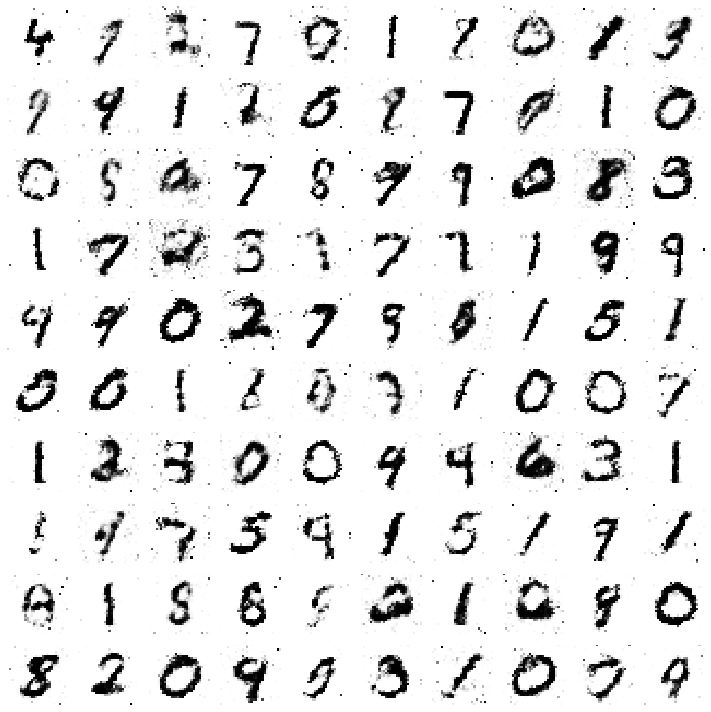

--------------- Epoch 22 ---------------
--------------- Epoch 23 ---------------
--------------- Epoch 24 ---------------
--------------- Epoch 25 ---------------
--------------- Epoch 26 ---------------


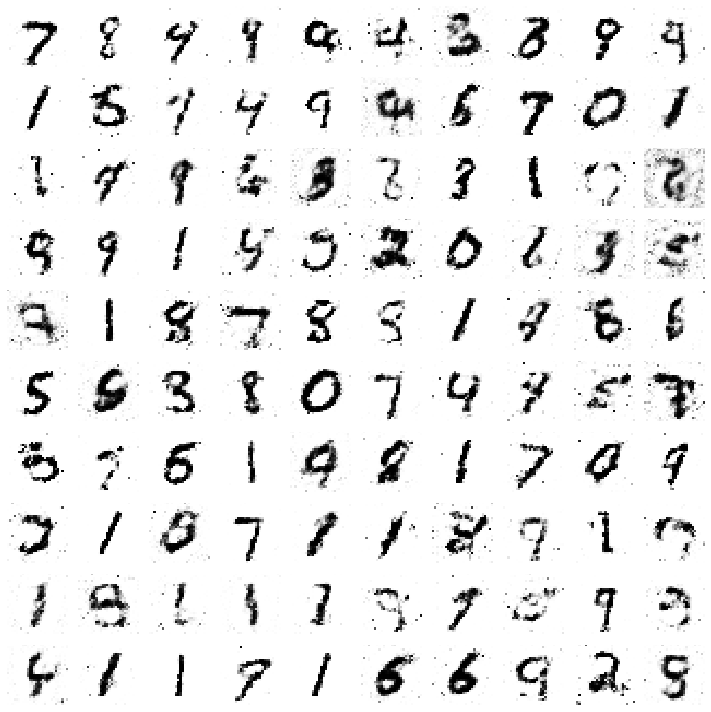

--------------- Epoch 27 ---------------
--------------- Epoch 28 ---------------
--------------- Epoch 29 ---------------
--------------- Epoch 30 ---------------
--------------- Epoch 31 ---------------


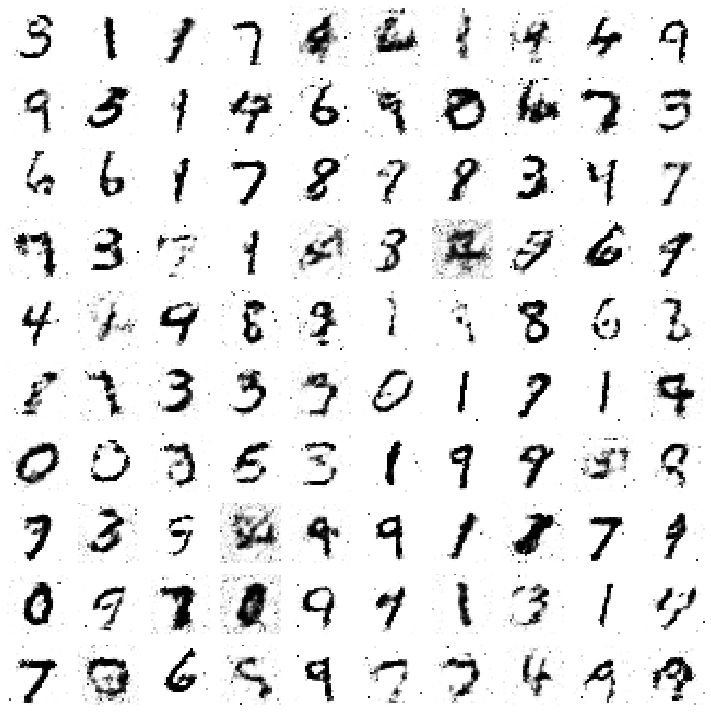

--------------- Epoch 32 ---------------
--------------- Epoch 33 ---------------
--------------- Epoch 34 ---------------
--------------- Epoch 35 ---------------
--------------- Epoch 36 ---------------


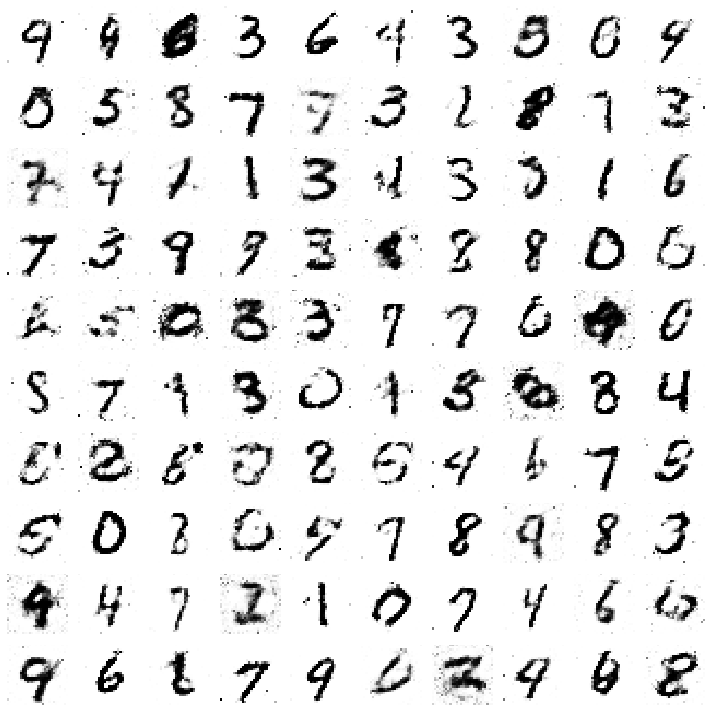

--------------- Epoch 37 ---------------
--------------- Epoch 38 ---------------
--------------- Epoch 39 ---------------
--------------- Epoch 40 ---------------
--------------- Epoch 41 ---------------


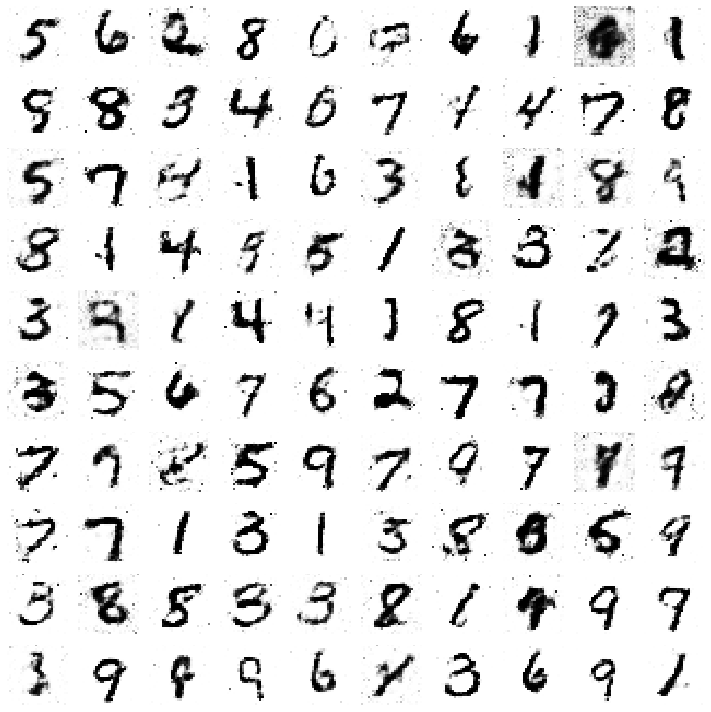

--------------- Epoch 42 ---------------
--------------- Epoch 43 ---------------
--------------- Epoch 44 ---------------
--------------- Epoch 45 ---------------
--------------- Epoch 46 ---------------


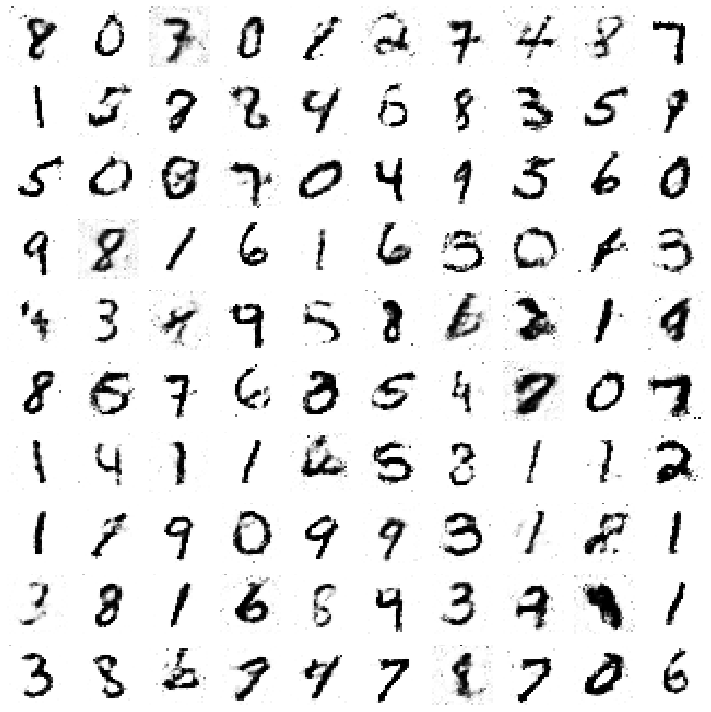

--------------- Epoch 47 ---------------
--------------- Epoch 48 ---------------
--------------- Epoch 49 ---------------
--------------- Epoch 50 ---------------
--------------- Epoch 51 ---------------


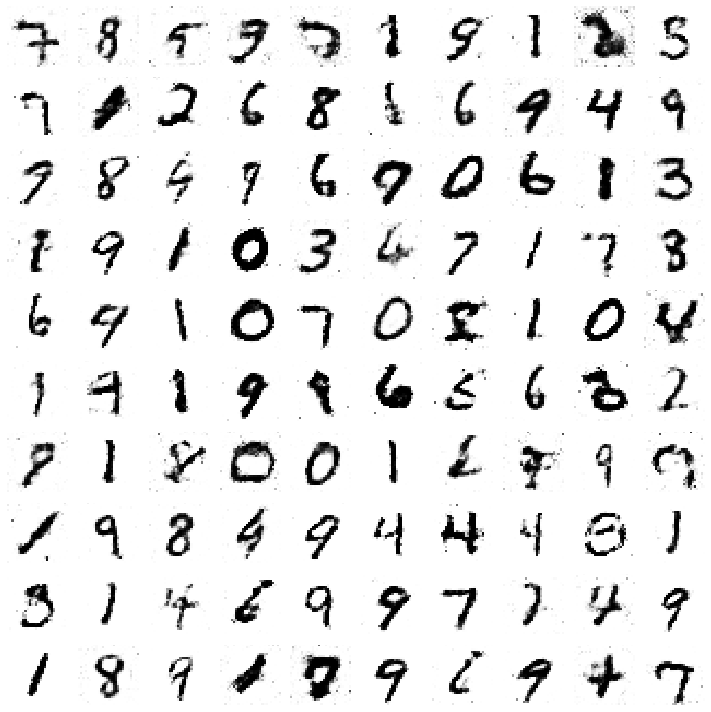

--------------- Epoch 52 ---------------
--------------- Epoch 53 ---------------
--------------- Epoch 54 ---------------
--------------- Epoch 55 ---------------
--------------- Epoch 56 ---------------


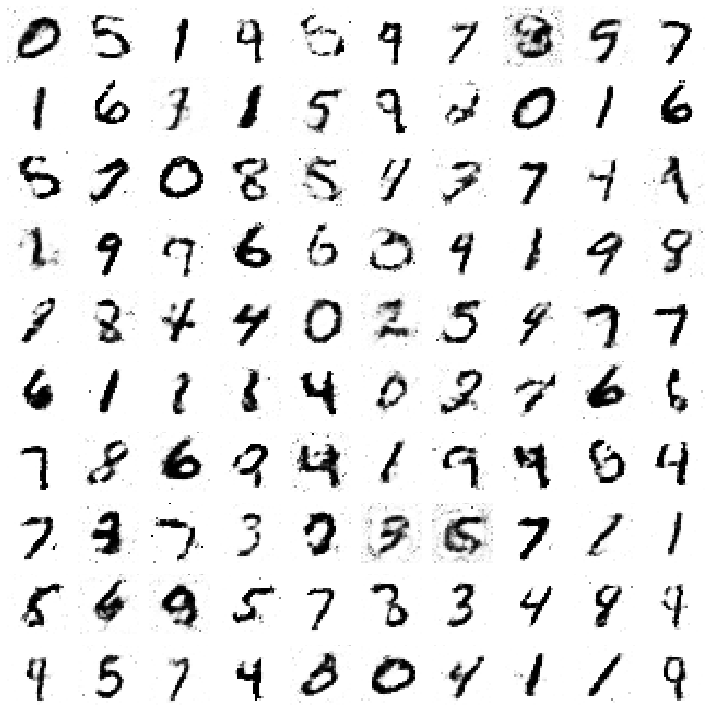

--------------- Epoch 57 ---------------
--------------- Epoch 58 ---------------
--------------- Epoch 59 ---------------
--------------- Epoch 60 ---------------
--------------- Epoch 61 ---------------


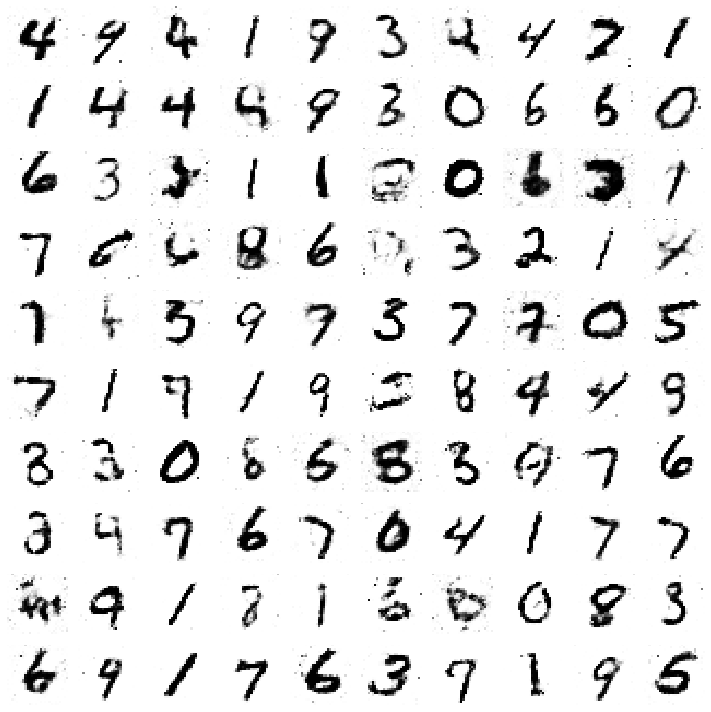

--------------- Epoch 62 ---------------
--------------- Epoch 63 ---------------
--------------- Epoch 64 ---------------
--------------- Epoch 65 ---------------
--------------- Epoch 66 ---------------


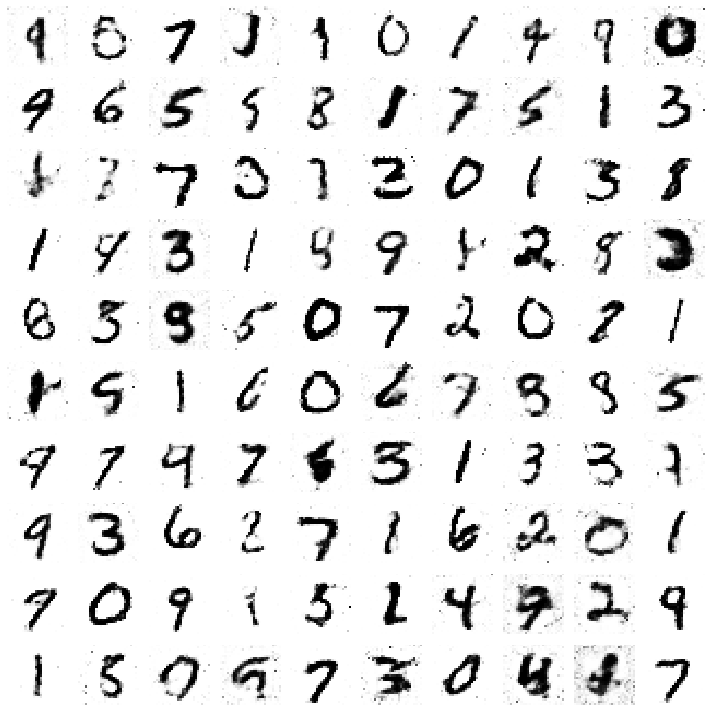

--------------- Epoch 67 ---------------
--------------- Epoch 68 ---------------
--------------- Epoch 69 ---------------
--------------- Epoch 70 ---------------
--------------- Epoch 71 ---------------


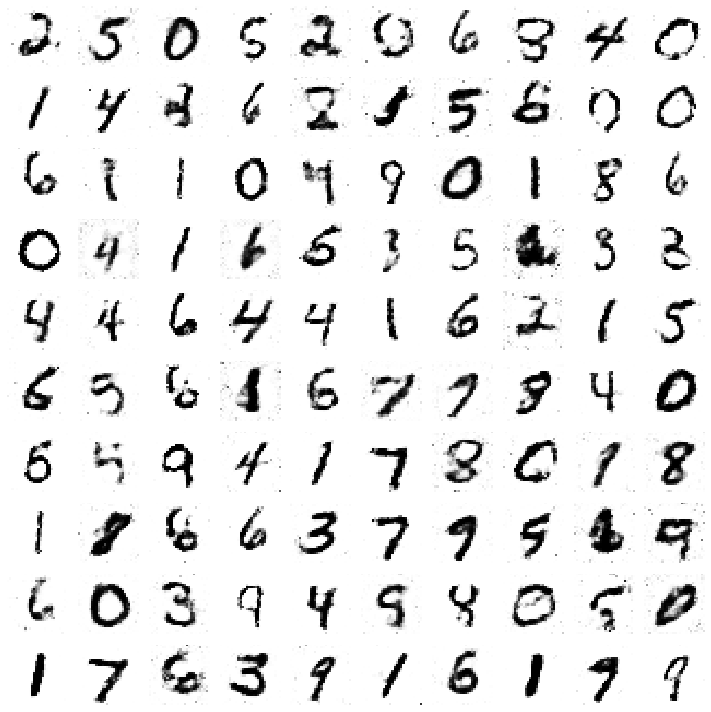

--------------- Epoch 72 ---------------
--------------- Epoch 73 ---------------
--------------- Epoch 74 ---------------
--------------- Epoch 75 ---------------
--------------- Epoch 76 ---------------


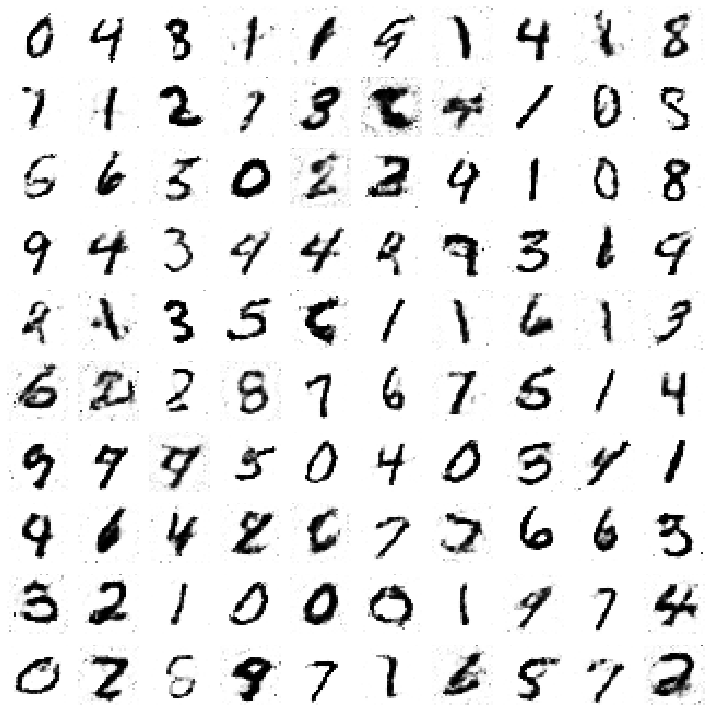

--------------- Epoch 77 ---------------
--------------- Epoch 78 ---------------
--------------- Epoch 79 ---------------
--------------- Epoch 80 ---------------
--------------- Epoch 81 ---------------


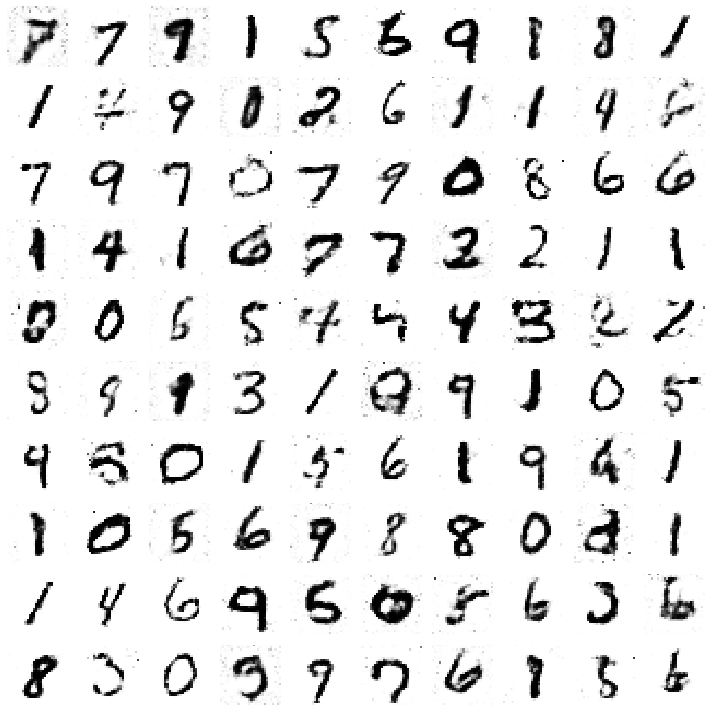

--------------- Epoch 82 ---------------
--------------- Epoch 83 ---------------
--------------- Epoch 84 ---------------
--------------- Epoch 85 ---------------
--------------- Epoch 86 ---------------


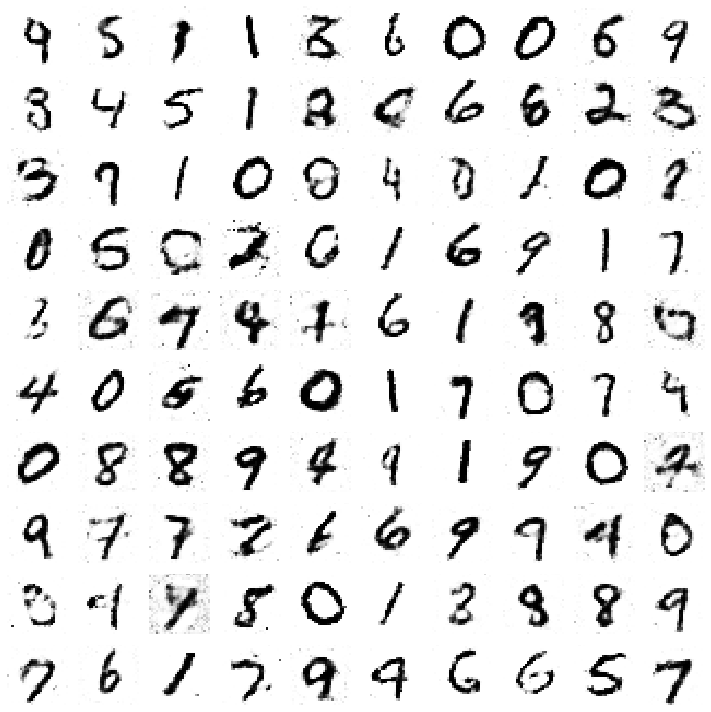

--------------- Epoch 87 ---------------
--------------- Epoch 88 ---------------
--------------- Epoch 89 ---------------
--------------- Epoch 90 ---------------
--------------- Epoch 91 ---------------


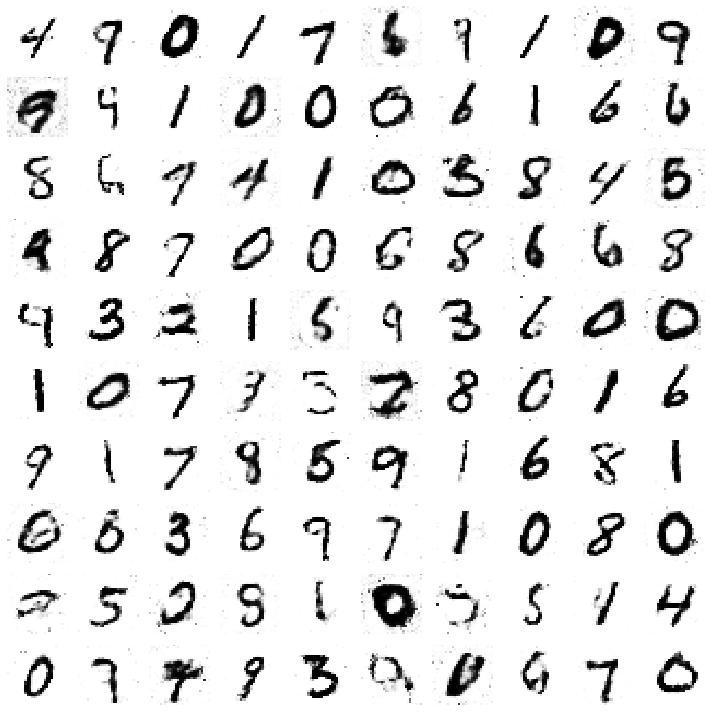

--------------- Epoch 92 ---------------
--------------- Epoch 93 ---------------
--------------- Epoch 94 ---------------
--------------- Epoch 95 ---------------
--------------- Epoch 96 ---------------


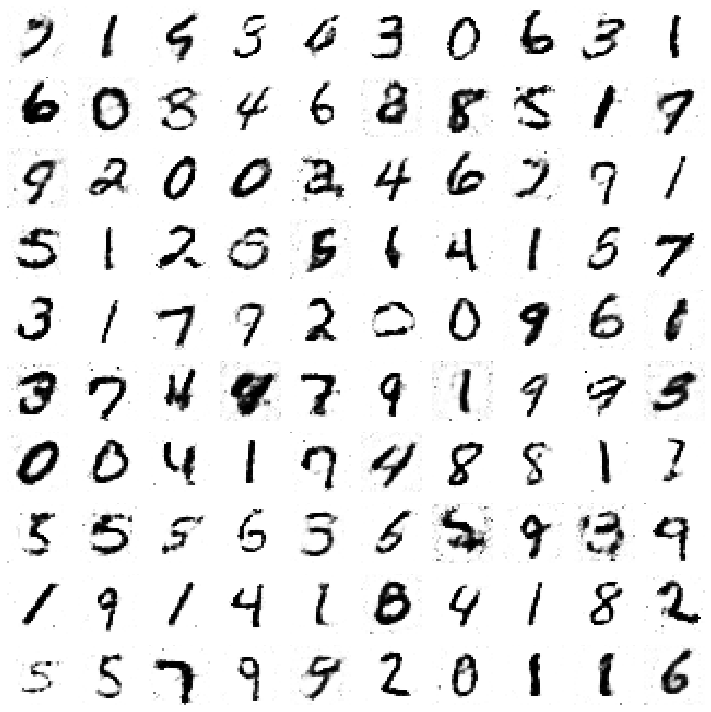

--------------- Epoch 97 ---------------
--------------- Epoch 98 ---------------
--------------- Epoch 99 ---------------
--------------- Epoch 100 ---------------
--------------- Epoch 101 ---------------


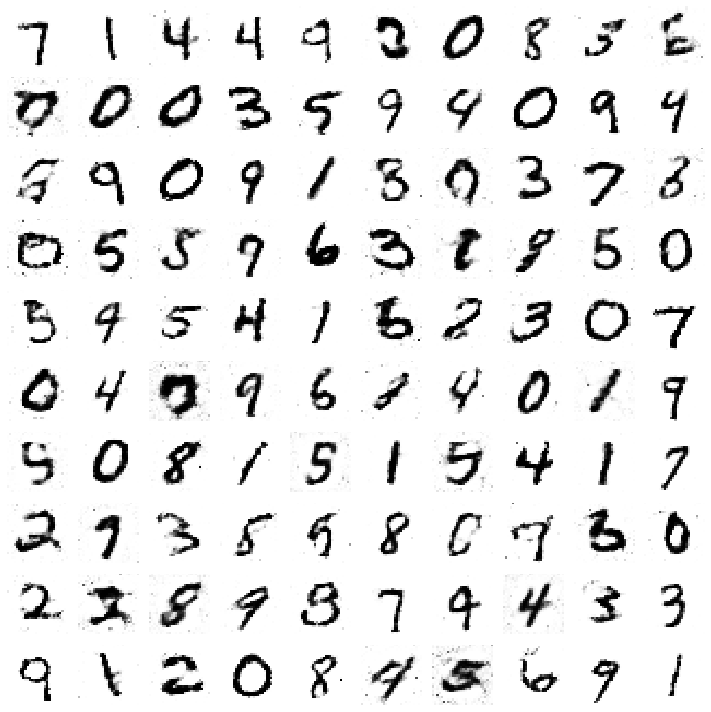

--------------- Epoch 102 ---------------
--------------- Epoch 103 ---------------
--------------- Epoch 104 ---------------
--------------- Epoch 105 ---------------
--------------- Epoch 106 ---------------


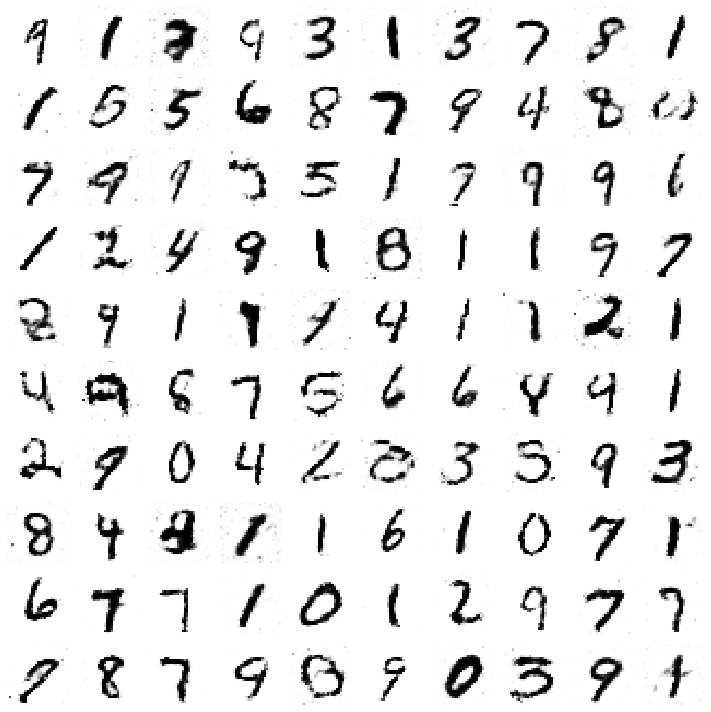

--------------- Epoch 107 ---------------
--------------- Epoch 108 ---------------
--------------- Epoch 109 ---------------
--------------- Epoch 110 ---------------
--------------- Epoch 111 ---------------


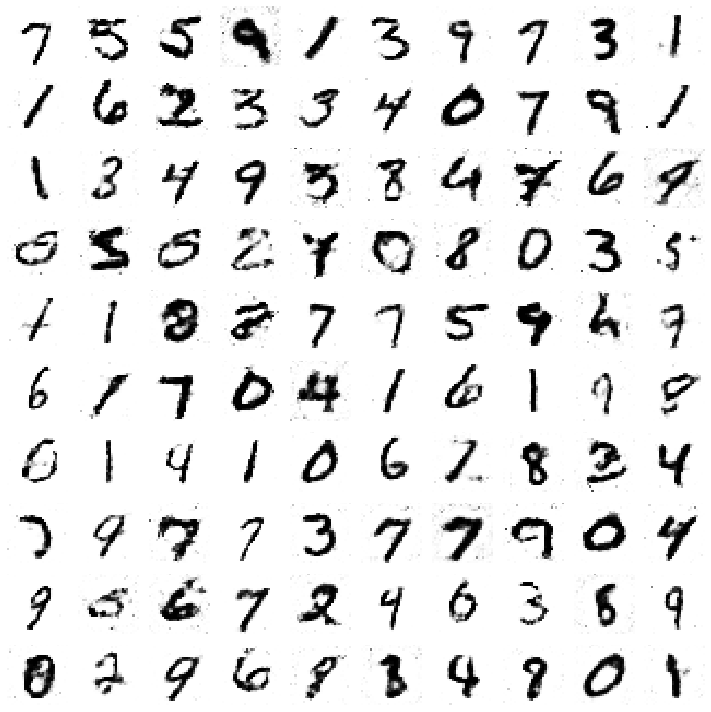

--------------- Epoch 112 ---------------
--------------- Epoch 113 ---------------
--------------- Epoch 114 ---------------
--------------- Epoch 115 ---------------
--------------- Epoch 116 ---------------


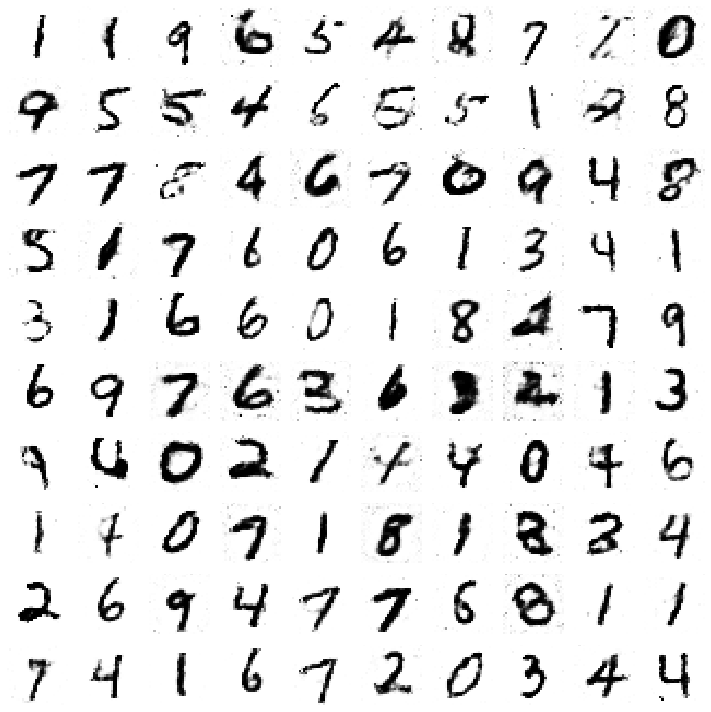

--------------- Epoch 117 ---------------
--------------- Epoch 118 ---------------
--------------- Epoch 119 ---------------
--------------- Epoch 120 ---------------
--------------- Epoch 121 ---------------


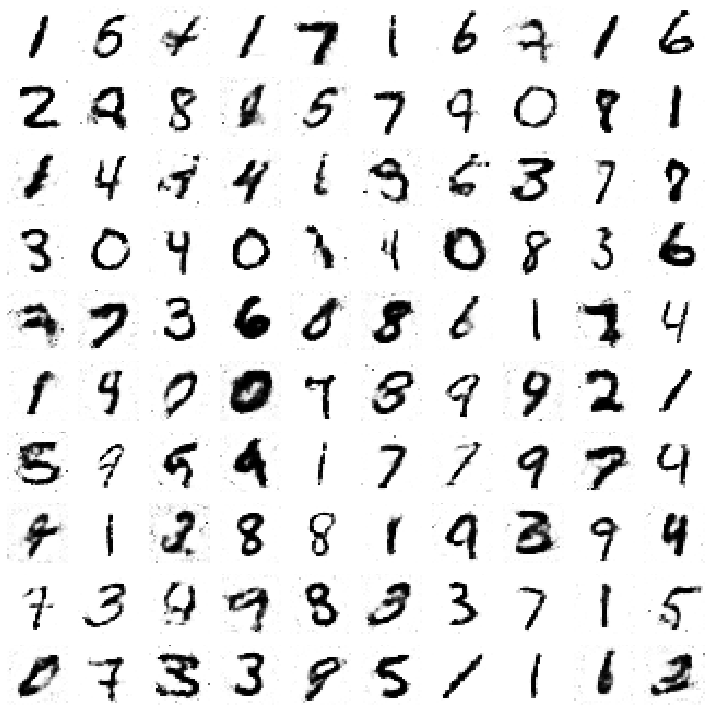

--------------- Epoch 122 ---------------
--------------- Epoch 123 ---------------
--------------- Epoch 124 ---------------
--------------- Epoch 125 ---------------
--------------- Epoch 126 ---------------


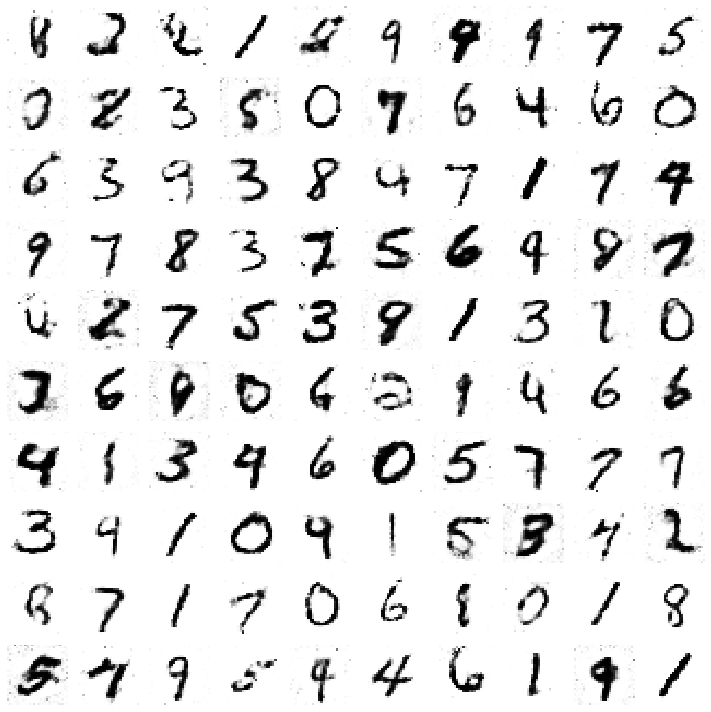

--------------- Epoch 127 ---------------
--------------- Epoch 128 ---------------
--------------- Epoch 129 ---------------
--------------- Epoch 130 ---------------
--------------- Epoch 131 ---------------


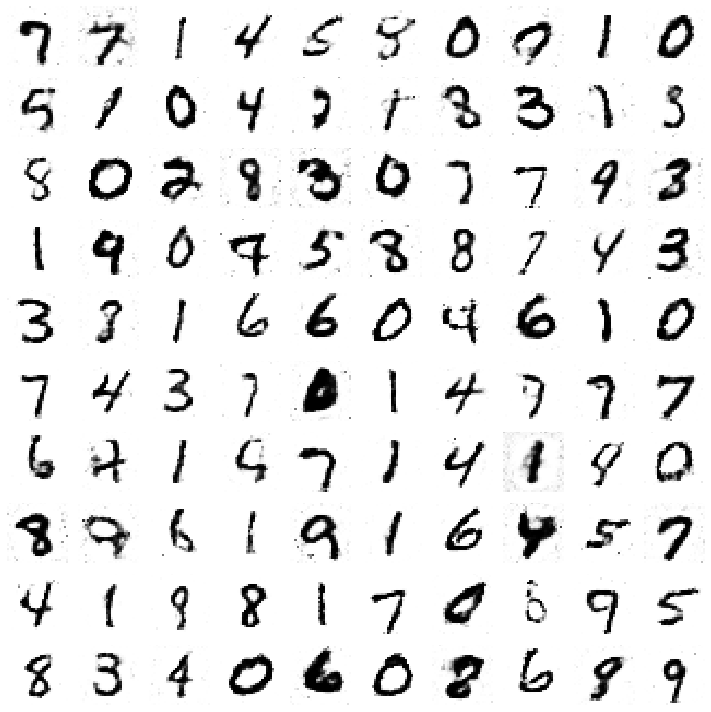

--------------- Epoch 132 ---------------
--------------- Epoch 133 ---------------
--------------- Epoch 134 ---------------
--------------- Epoch 135 ---------------
--------------- Epoch 136 ---------------


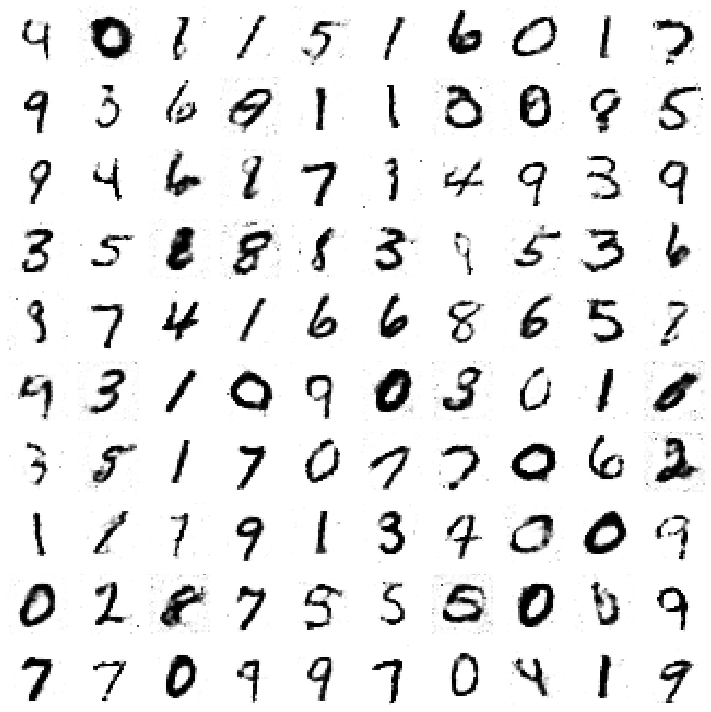

--------------- Epoch 137 ---------------
--------------- Epoch 138 ---------------
--------------- Epoch 139 ---------------
--------------- Epoch 140 ---------------
--------------- Epoch 141 ---------------


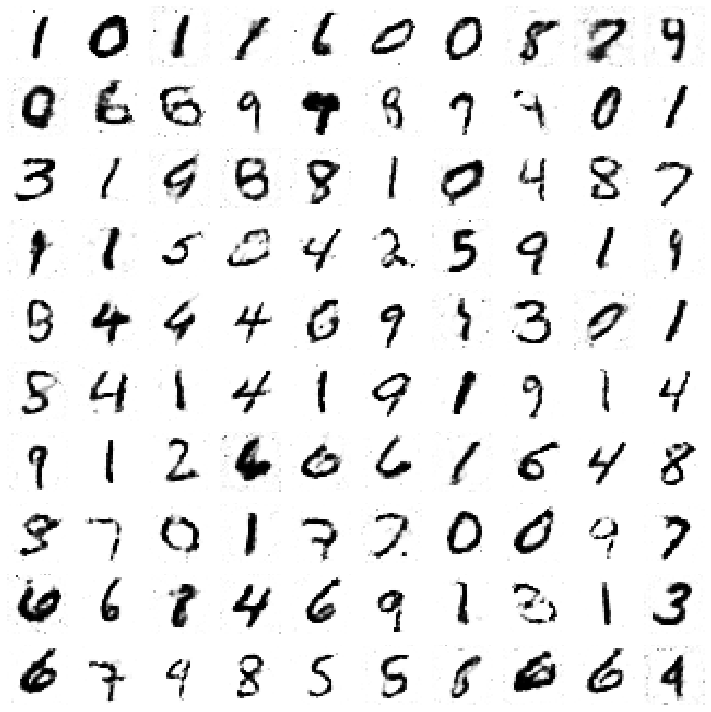

--------------- Epoch 142 ---------------
--------------- Epoch 143 ---------------
--------------- Epoch 144 ---------------
--------------- Epoch 145 ---------------
--------------- Epoch 146 ---------------


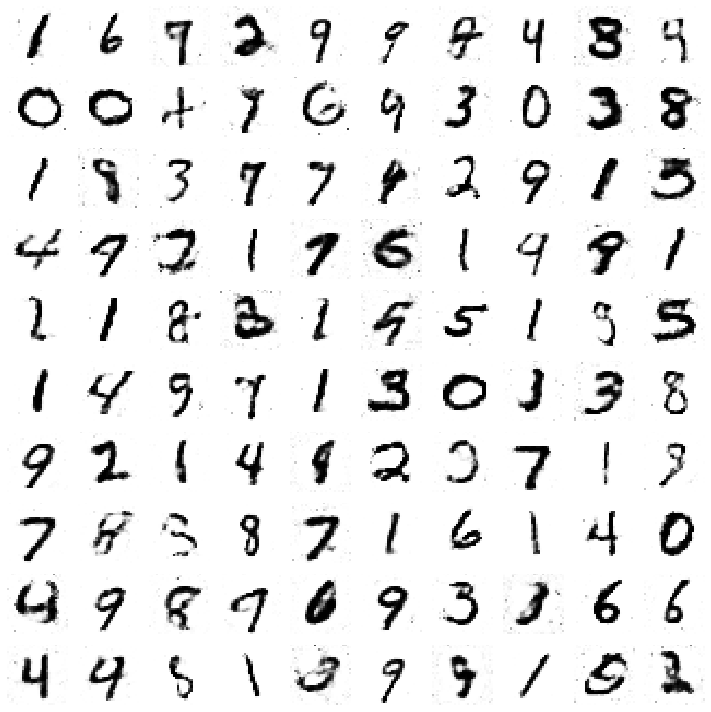

--------------- Epoch 147 ---------------
--------------- Epoch 148 ---------------
--------------- Epoch 149 ---------------
--------------- Epoch 150 ---------------
--------------- Epoch 151 ---------------


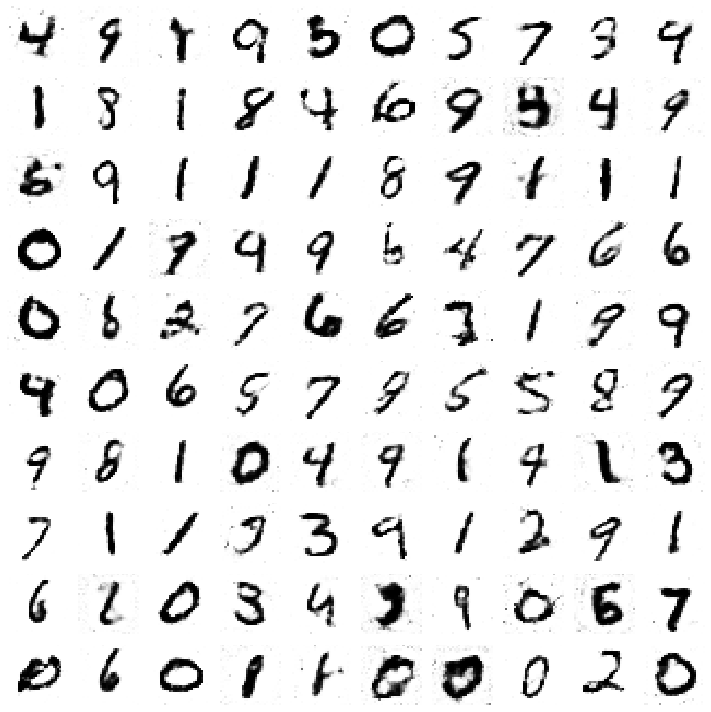

--------------- Epoch 152 ---------------
--------------- Epoch 153 ---------------
--------------- Epoch 154 ---------------
--------------- Epoch 155 ---------------
--------------- Epoch 156 ---------------


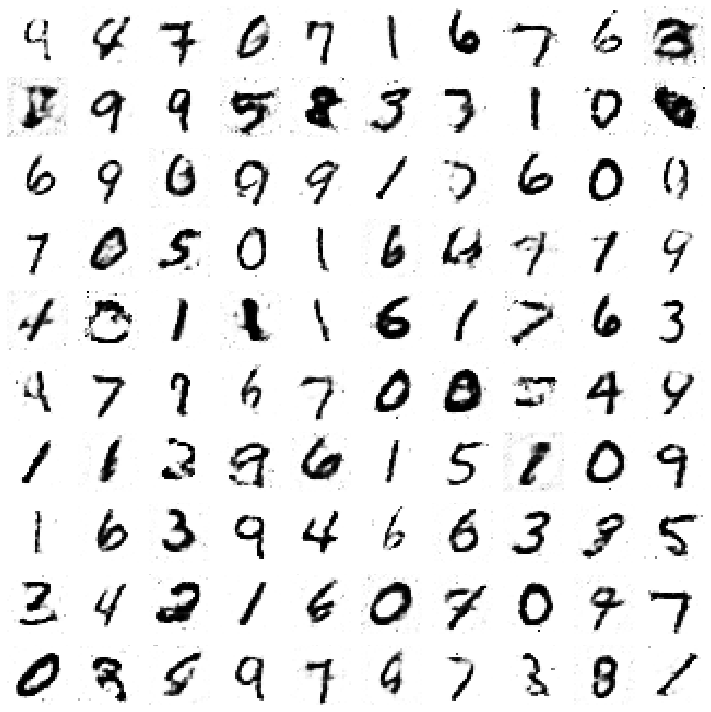

--------------- Epoch 157 ---------------
--------------- Epoch 158 ---------------
--------------- Epoch 159 ---------------
--------------- Epoch 160 ---------------
--------------- Epoch 161 ---------------


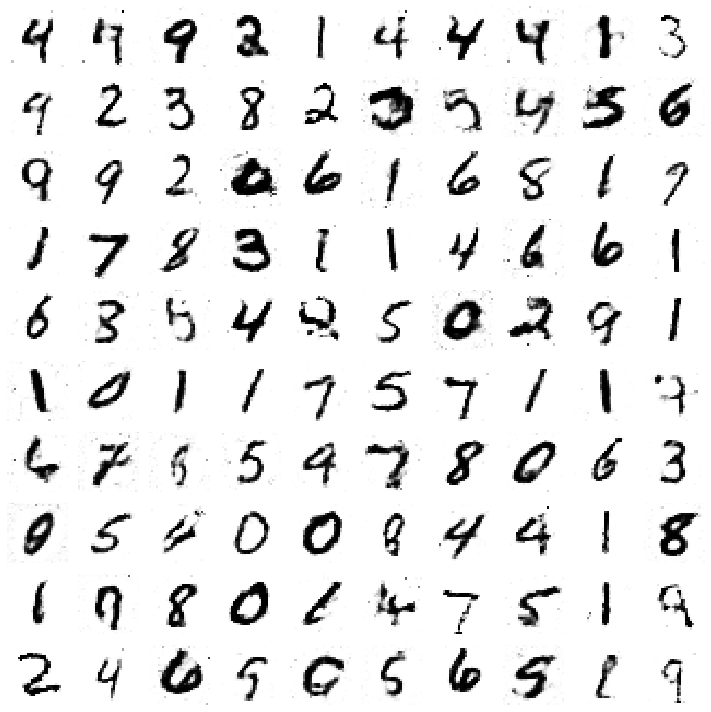

--------------- Epoch 162 ---------------
--------------- Epoch 163 ---------------
--------------- Epoch 164 ---------------
--------------- Epoch 165 ---------------
--------------- Epoch 166 ---------------


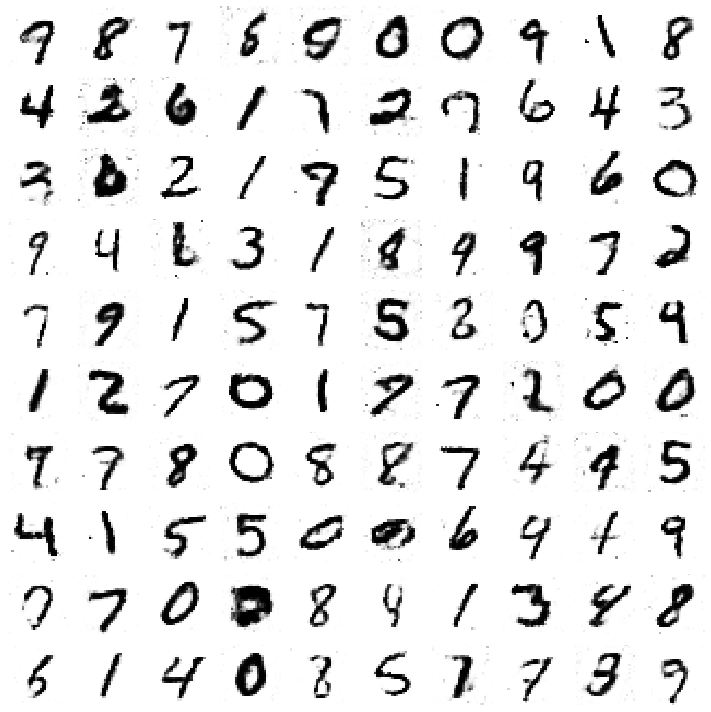

--------------- Epoch 167 ---------------
--------------- Epoch 168 ---------------
--------------- Epoch 169 ---------------
--------------- Epoch 170 ---------------
--------------- Epoch 171 ---------------


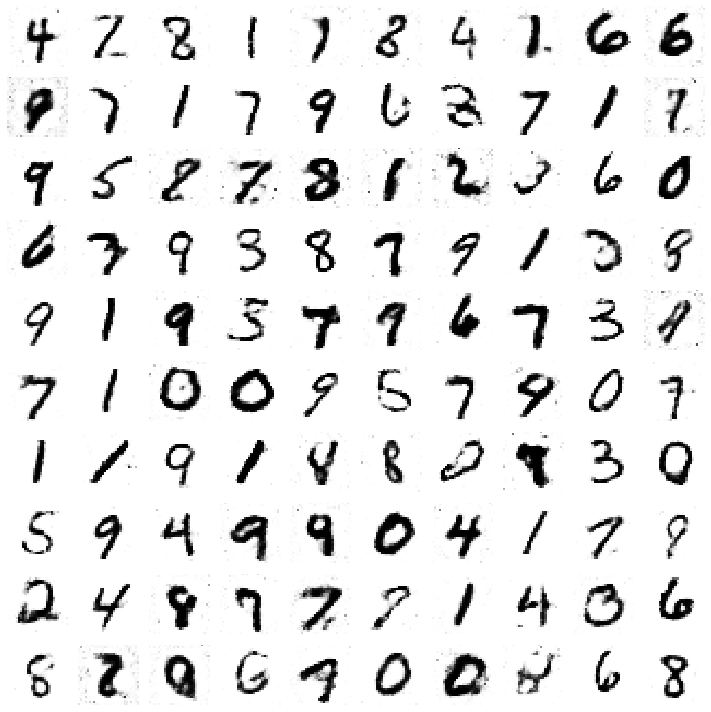

--------------- Epoch 172 ---------------
--------------- Epoch 173 ---------------
--------------- Epoch 174 ---------------
--------------- Epoch 175 ---------------
--------------- Epoch 176 ---------------


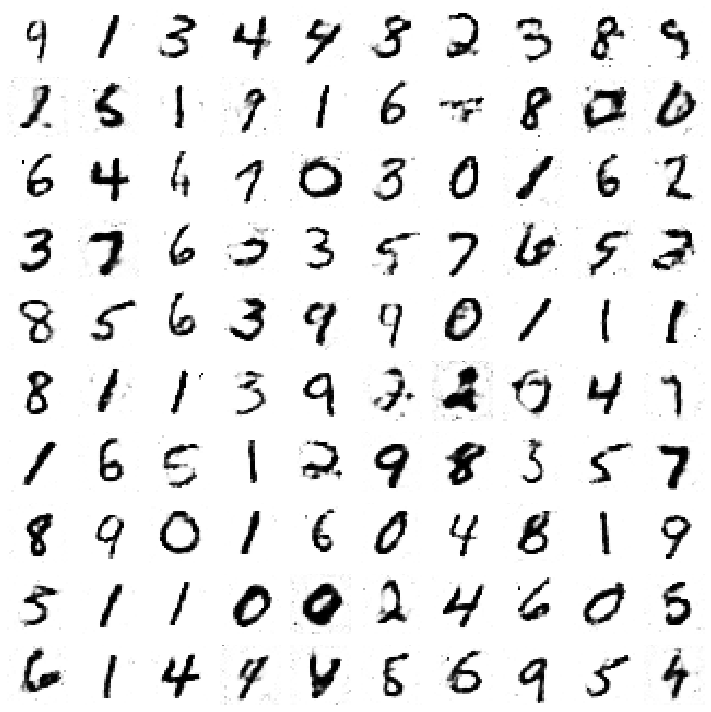

--------------- Epoch 177 ---------------
--------------- Epoch 178 ---------------
--------------- Epoch 179 ---------------
--------------- Epoch 180 ---------------
--------------- Epoch 181 ---------------


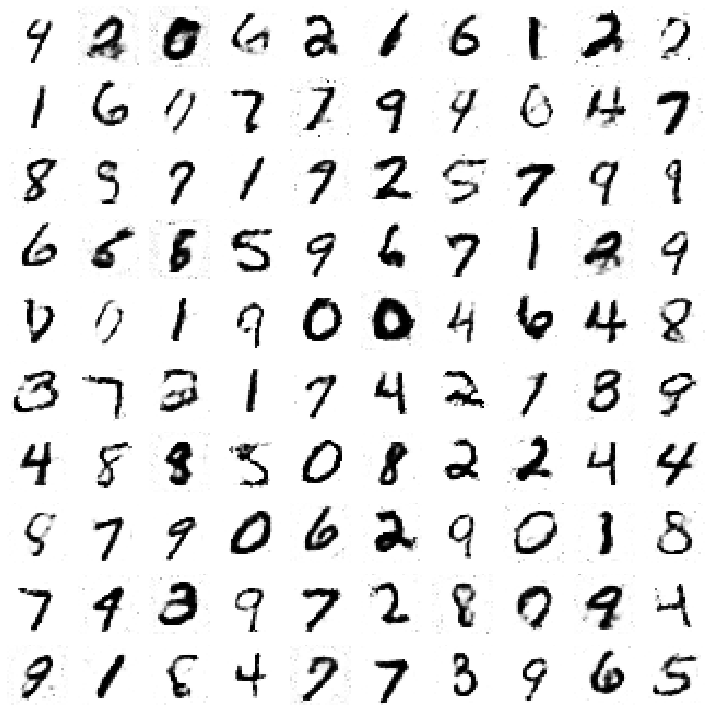

--------------- Epoch 182 ---------------
--------------- Epoch 183 ---------------
--------------- Epoch 184 ---------------
--------------- Epoch 185 ---------------
--------------- Epoch 186 ---------------


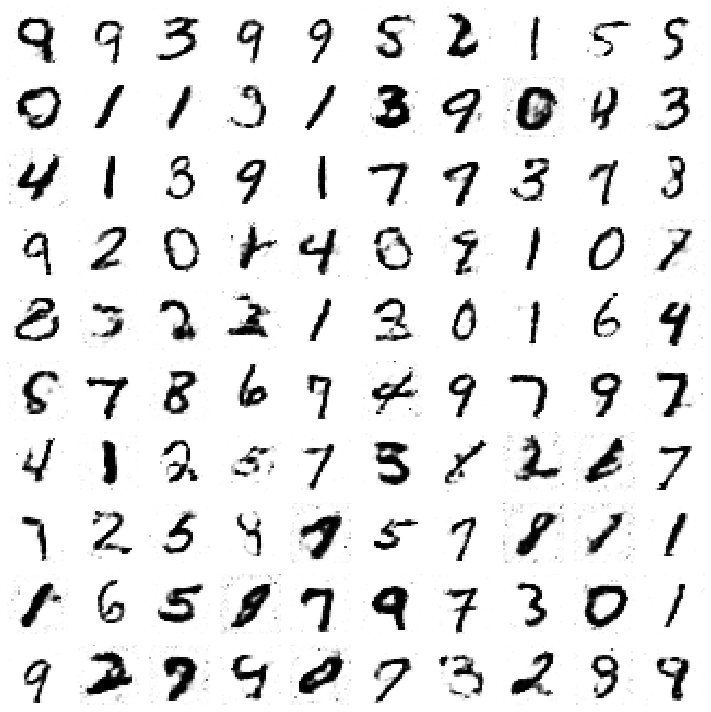

--------------- Epoch 187 ---------------
--------------- Epoch 188 ---------------
--------------- Epoch 189 ---------------
--------------- Epoch 190 ---------------
--------------- Epoch 191 ---------------


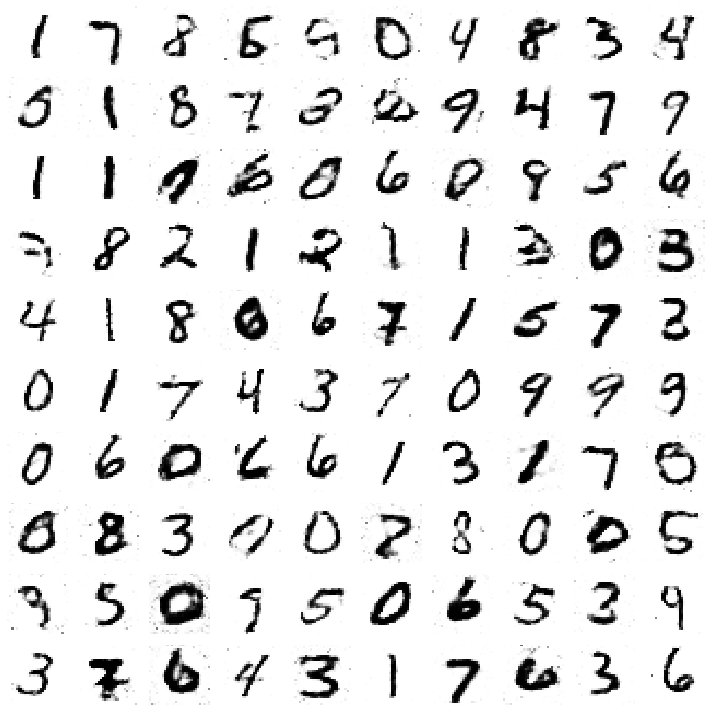

--------------- Epoch 192 ---------------
--------------- Epoch 193 ---------------
--------------- Epoch 194 ---------------
--------------- Epoch 195 ---------------
--------------- Epoch 196 ---------------


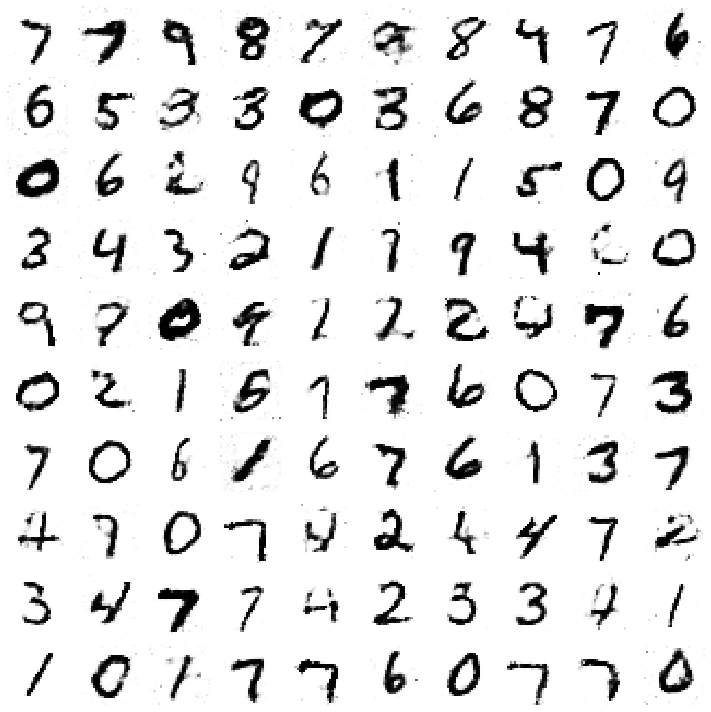

--------------- Epoch 197 ---------------
--------------- Epoch 198 ---------------
--------------- Epoch 199 ---------------
--------------- Epoch 200 ---------------


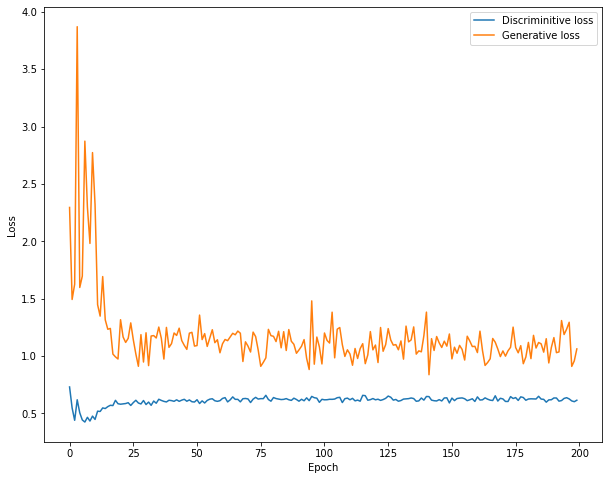

In [8]:
train()